<a href="https://colab.research.google.com/github/thor4/neuralnets/blob/master/state_farm_task-step_2-build_your_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# State Farm Pre-employment Assessment
### *Model-based supervised learning binary classification task*
Your work will be evaluated in the following areas:
- The appropriateness of the steps you took
- The complexity of your models
- The performance of each model on the test set (using AUC)
- The organization and readability of your code
- The write-up comparing the models
---

## Step 1 - Clean and prepare your data
The data in this exercise have been simulated to mimic real, dirty data. Please clean the data with whatever method(s) you believe to be best/most suitable. Success in this exercise typically involves feature engineering and avoiding data leakage. You may create new features. However, you may not add or supplement with external data. 

We will begin by importing relevant libraries.

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer, QuantileTransformer, LabelEncoder, KBinsDiscretizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc

Next, we use the pandas library to load our CSV data.

In [2]:
train_data = pd.read_csv("exercise_40_train.csv")
test_data = pd.read_csv("exercise_40_test.csv")

In [3]:
train_data.head()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x91,x92,x93,x94,x95,x96,x97,x98,x99,x100
0,0,0.165254,18.060003,Wed,1.077380,-1.339233,-1.584341,0.0062%,0.220784,1.816481,...,-0.397427,0.909479,no,5.492487,NaN,10.255579,7.627730,0,yes,104.251338
1,1,2.441471,18.416307,Friday,1.482586,0.920817,-0.759931,0.0064%,1.192441,3.513950,...,0.656651,9.093466,no,3.346429,4.321172,NaN,10.505284,1,yes,101.230645
2,1,4.427278,19.188092,Thursday,0.145652,0.366093,0.709962,-8e-04%,0.952323,0.782974,...,2.059615,0.305170,no,4.456565,NaN,8.754572,7.810979,0,yes,109.345215
3,0,3.925235,19.901257,Tuesday,1.763602,-0.251926,-0.827461,-0.0057%,-0.520756,1.825586,...,0.899392,5.971782,no,4.100022,1.151085,NaN,9.178325,1,yes,103.021970
4,0,2.868802,22.202473,Sunday,3.405119,0.083162,1.381504,0.0109%,-0.732739,2.151990,...,3.003595,1.046096,yes,3.234033,2.074927,9.987006,11.702664,0,yes,92.925935


### Prepare the data

Separate the predictors from the labels

In [3]:
train = train_data.drop("y", axis=1)
train_labels = train_data["y"].copy()

Drop unnecessary columns

In [4]:
train = train.drop(columns=["x39", "x99", "x79", "x28"])

Convert object columns to binary int64


In [5]:
binary_features = ["x24", "x31", "x93"]
for col in binary_features:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col].astype(str))

Replace null values in `x33` and `x77` with most likely value based on probabilities

In [6]:
for col in ["x33", "x77"]:
    probs = train[col].value_counts(normalize=True)
    missing = train[col].isna()
    train.loc[missing, col] = np.random.choice(probs.index, size=len(train[missing]), p=probs.values)

Combine duplicate days in `x3`

In [7]:
day_mapping = {
    "Mon": "Monday",
    "Tue": "Tuesday",
    "Wed": "Wednesday",
    "Thur": "Thursday",
    "Fri": "Friday",
    "Sat": "Saturday",
    "Sun": "Sunday"
}
train["x3"] = train["x3"].replace(day_mapping)

Convert the `x7` column to a float by removing the % sign and dividing by 100. Convert the `x19` column to a float by removing the $ sign.

In [8]:
train['x7'] = train['x7'].str.strip('%').astype(float) / 100
train['x19'] = train['x19'].str.strip('$').astype(float)

### Create and run preprocessing pipeline

In [9]:
# Define transformers for each group of columns
one_hot_features = ["x33", "x77", "x3", "x60", "x65"]
range_based_features = ["x58", "x67", "x71", "x84"]
quantile_transform_features = ["x12", "x18", "x61", "x92", "x40", "x57"]
log_transform_features = ["x14", "x16", "x21", "x42", "x45", "x55", "x70", "x73", "x75", "x82", "x89", "x96"]

one_hot_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("one_hot", OneHotEncoder())
])

def custom_discretizer(X, low_quantile=0.25, high_quantile=0.75):
    low_bound = np.quantile(X, low_quantile, axis=0)
    high_bound = np.quantile(X, high_quantile, axis=0)
    return np.where(X < low_bound, 0, np.where(X <= high_bound, 1, 2))

range_based_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("custom_discretizer", FunctionTransformer(custom_discretizer, validate=True)),
    ("one_hot", OneHotEncoder())
])

quantile_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("quantile_transform", QuantileTransformer(output_distribution="normal"))
])

def log1p_with_positive_shift(X):
    positive_shift = np.abs(np.min(X, axis=0)) + 1e-6
    return np.log1p(X + positive_shift)

log_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("log_transform", FunctionTransformer(log1p_with_positive_shift, validate=True)),
    ("standard_scaler", StandardScaler())
])

remaining_float_features = list(set(train.select_dtypes(include=["float64"]).columns) - set(range_based_features) - set(quantile_transform_features) - set(log_transform_features))

float_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("standard_scaler", StandardScaler())
])

# Create ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ("one_hot", one_hot_transformer, one_hot_features),
    ("range_based", range_based_transformer, range_based_features),
    ("quantile_transform", quantile_transformer, quantile_transform_features),
    ("log_transform", log_transformer, log_transform_features),
    ("float_transform", float_transformer, remaining_float_features)
])

# Apply the preprocessing pipeline
X_transformed = preprocessor.fit_transform(train)

# Get the column names from the transformers
one_hot_cols = preprocessor.named_transformers_["one_hot"].named_steps["one_hot"].get_feature_names_out(one_hot_features)
range_based_categories = ["low", "middle", "high"]
range_based_cols = [f"{col}_{cat}" for col in range_based_features for cat in range_based_categories]
quantile_transform_cols = [f"quantile_{col}" for col in quantile_transform_features]
log_transform_cols = [f"log_{col}" for col in log_transform_features]
float_transform_cols = [f"float_{col}" for col in remaining_float_features]

print("One-hot cols:", len(one_hot_cols))
print("Range-based cols:", len(range_based_cols))
print("Quantile transform cols:", len(quantile_transform_cols))
print("Log transform cols:", len(log_transform_cols))
print("Float transform cols:", len(float_transform_cols))

# Combine column names
columns = (list(one_hot_cols)
           + list(range_based_cols)
           + quantile_transform_cols
           + log_transform_cols
           + float_transform_cols)

print("Total expected columns:", len(columns))
print("Actual columns in transformed dataset:", X_transformed.shape[1])

train_transformed = pd.DataFrame(X_transformed, columns=columns)

One-hot cols: 82
Range-based cols: 12
Quantile transform cols: 6
Log transform cols: 12
Float transform cols: 64
Total expected columns: 176
Actual columns in transformed dataset: 176


In [92]:
train_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Columns: 176 entries, x33_Alabama to float_x41
dtypes: float64(176)
memory usage: 53.7 MB


In [10]:
train_transformed.columns[train_transformed.isnull().sum() != 0]

Index([], dtype='object')

Split the processed training data into train & test sets.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, train_labels, test_size=0.2, random_state=42)

Train a logistic regression model and output mean accuracy score.

In [12]:
logistic_regression = LogisticRegression(max_iter=1000, random_state=42)
logistic_regression.fit(X_train, y_train)

logreg_train_score = logistic_regression.score(X_train, y_train)
logreg_test_score = logistic_regression.score(X_test, y_test)

print(f"Logistic Regression train score: {logreg_train_score}")
print(f"Logistic Regression test score: {logreg_test_score}")

Logistic Regression train score: 0.858
Logistic Regression test score: 0.858


Compare this accuracy with a logistic regression model trained on data pre-processed in a more naive fashion.

In [13]:
numeric_features = train.select_dtypes(include=["float64"]).columns
categorical_features = train.select_dtypes(include=["object"]).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

simpler_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

X_simpler_transformed = simpler_preprocessor.fit_transform(train)

X_train_simpler, X_test_simpler, y_train_simpler, y_test_simpler = train_test_split(X_simpler_transformed, train_labels, test_size=0.2, random_state=42)


In [14]:
logistic_regression_simpler = LogisticRegression(max_iter=1000, random_state=42)
logistic_regression_simpler.fit(X_train_simpler, y_train_simpler)

logreg_simpler_train_score = logistic_regression_simpler.score(X_train_simpler, y_train_simpler)
logreg_simpler_test_score = logistic_regression_simpler.score(X_test_simpler, y_test_simpler)

print(f"Simpler Logistic Regression train score: {logreg_simpler_train_score}")
print(f"Simpler Logistic Regression test score: {logreg_simpler_test_score}")


Simpler Logistic Regression train score: 0.85815625
Simpler Logistic Regression test score: 0.859125


The sophisticated preprocessing we did does not seem to matter when only looking at mean accuracy. However, that is not a good metric for a binary classification problem. Let's shift our focus to the AUC metric and test another logistic regression model which uses stochastic gradient descent for optimization.

First, train the new logistic regression models.

In [16]:
sgd_log = SGDClassifier(loss='log_loss', random_state=42)
sgd_log.fit(X_train, y_train)
sgd_log_simpler = SGDClassifier(loss='log_loss', random_state=42)
sgd_log_simpler.fit(X_train_simpler, y_train_simpler)

SGDClassifier(loss='log_loss', random_state=42)

In [24]:
X_test_simpler[:,1].shape

(8000,)

In [25]:
logreg_auc_train = roc_auc_score(y_train, logistic_regression.predict_proba(X_train)[:, 1])
logreg_auc_test = roc_auc_score(y_test, logistic_regression.predict_proba(X_test)[:, 1])
logreg_auc_train_simpler = roc_auc_score(y_train_simpler, logistic_regression_simpler.predict_proba(X_train_simpler)[:, 1])
logreg_auc_test_simpler = roc_auc_score(y_test_simpler, logistic_regression_simpler.predict_proba(X_test_simpler)[:, 1])

sgd_log_auc_train = roc_auc_score(y_train, sgd_log.predict_proba(X_train)[:, 1])
sgd_log_auc_test = roc_auc_score(y_test, sgd_log.predict_proba(X_test)[:, 1])
sgd_log_auc_train_simpler = roc_auc_score(y_train_simpler, sgd_log_simpler.predict_proba(X_train_simpler)[:, 1])
sgd_log_auc_test_simpler = roc_auc_score(y_test_simpler, sgd_log_simpler.predict_proba(X_test_simpler)[:, 1])

print(f"Logistic Regression AUC train score: {logreg_auc_train}")
print(f"Logistic Regression AUC test score: {logreg_auc_test}")
print(f"Simpler Logistic Regression AUC train score: {logreg_auc_train_simpler}")
print(f"Simpler Logistic Regression AUC test score: {logreg_auc_test_simpler}")
print(f"SGDClassifier with log loss AUC train score: {sgd_log_auc_train}")
print(f"SGDClassifier with log loss AUC test score: {sgd_log_auc_test}")
print(f"Simpler SGDClassifier with log loss AUC train score: {sgd_log_auc_train_simpler}")
print(f"Simpler SGDClassifier with log loss AUC test score: {sgd_log_auc_test_simpler}")


Logistic Regression AUC train score: 0.7587282979820895
Logistic Regression AUC test score: 0.7546500930191609
Simpler Logistic Regression AUC train score: 0.758262563363822
Simpler Logistic Regression AUC test score: 0.754847319014393
SGDClassifier with log loss AUC train score: 0.7370401893849453
SGDClassifier with log loss AUC test score: 0.7331199089197795
Simpler SGDClassifier with log loss AUC train score: 0.7338784707382703
Simpler SGDClassifier with log loss AUC test score: 0.7267721537399059


The simpler preprocessing step appears to be just as effective as the sophisticated one according to the AUC metric. The SGDClassifier wasn't a better logistic regression optimizer in this case; perhaps because the dataset wasn't large enough to make a difference.

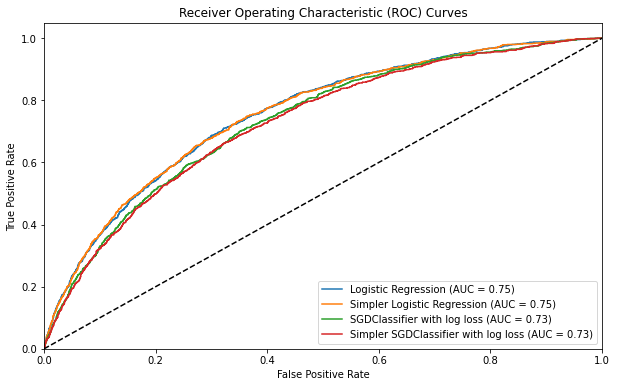

In [28]:
# Calculate the ROC curves for all models
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, logistic_regression.predict_proba(X_test)[:, 1])
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)

fpr_logreg_simpler, tpr_logreg_simpler, _ = roc_curve(y_test_simpler, logistic_regression_simpler.predict_proba(X_test_simpler)[:, 1])
roc_auc_logreg_simpler = auc(fpr_logreg_simpler, tpr_logreg_simpler)

fpr_sgd_log, tpr_sgd_log, _ = roc_curve(y_test, sgd_log.predict_proba(X_test)[:, 1])
roc_auc_sgd_log = auc(fpr_sgd_log, tpr_sgd_log)

fpr_sgd_log_simpler, tpr_sgd_log_simpler, _ = roc_curve(y_test_simpler, sgd_log_simpler.predict_proba(X_test_simpler)[:, 1])
roc_auc_sgd_log_simpler = auc(fpr_sgd_log_simpler, tpr_sgd_log_simpler)

# Plot the ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (AUC = {roc_auc_logreg:.2f})')
plt.plot(fpr_logreg_simpler, tpr_logreg_simpler, label=f'Simpler Logistic Regression (AUC = {roc_auc_logreg_simpler:.2f})')
plt.plot(fpr_sgd_log, tpr_sgd_log, label=f'SGDClassifier with log loss (AUC = {roc_auc_sgd_log:.2f})')
plt.plot(fpr_sgd_log_simpler, tpr_sgd_log_simpler, label=f'Simpler SGDClassifier with log loss (AUC = {roc_auc_sgd_log_simpler:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Read the data
data = pd.read_csv("data.csv")

# Define the simpler preprocessing pipeline
numeric_features = data.select_dtypes(include=["float64"]).columns
categorical_features = data.select_dtypes(include=["object"]).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

simpler_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Define the regular preprocessing pipeline
# (Assuming the custom transformers and column lists are already defined)

preprocessor = ColumnTransformer(transformers=[
    ("one_hot", one_hot_transformer, one_hot_features),
    ("range_based", range_based_transformer, range_based_features),
    ("quantile_transform", quantile_transformer, quantile_transform_features),
    ("log_transform", log_transformer, log_transform_features),
    ("float_transform", float_transformer, remaining_float_features)
])

# Set up the classifier models
classifiers = {
    'logistic_regression': LogisticRegression(random_state=42),
    'logistic_regression_simpler': LogisticRegression(random_state=42),
    'sgd_log': SGDClassifier(loss='log', random_state=42),
    'sgd_log_simpler': SGDClassifier(loss='log', random_state=42)
}

# Define the hyperparameters for GridSearchCV
param_grids = {
    'logistic_regression': {
        'classifier__C': [0.1, 1, 10],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    },
    'logistic_regression_simpler': {
        'classifier__C': [0.1, 1, 10],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    },
    'sgd_log': {
        'classifier__alpha': [0.0001, 0.001, 0.01],
        'classifier__penalty': ['l1', 'l2', 'elasticnet']
    },
    'sgd_log_simpler': {
        'classifier__alpha': [0.0001, 0.001, 0.01],
        'classifier__penalty': ['l1', 'l2', 'elasticnet']
    }
}

# Train and test functions
def train_and_test(preprocessor, classifier, params):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])
    
    X = data.drop("target", axis=1)


In [61]:
# Define pipelines and parameter grids for logistic_regression and sgd_log
logreg_param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__penalty': ['l1','l2'],
    'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

sgd_log_param_grid = {
    'classifier__alpha': [0.0001, 0.001, 0.01],
    'classifier__penalty': ['l2', 'l1', 'elasticnet'],
    'classifier__loss': ['log']
}

sgd_log_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SGDClassifier(max_iter=1000))
])

# Perform GridSearchCV and cross-validation for logistic_regression and sgd_log
models = [('logistic_regression', logreg_pipeline, logreg_param_grid),
          ('logistic_regression_simpler', logreg_pipeline, logreg_param_grid),
          ('sgd_log', sgd_log_pipeline, sgd_log_param_grid),
          ('sgd_log_simpler', sgd_log_pipeline, sgd_log_param_grid)]

X_train_sets = [X_train_transformed, X_train_simpler_transformed, X_train_transformed, X_train_simpler_transformed]
y_train_sets = [y_train, y_train_simpler, y_train, y_train_simpler]

for model, X_train_set, y_train_set in zip(models, X_train_sets, y_train_sets):
    model_name, pipeline, param_grid = model
    print(f"Performing GridSearchCV for {model_name}")
    grid_search = GridSearchCV(pipeline, param_grid, scoring='roc_auc', cv=5, verbose=1)
    grid_search.fit(X_train_set, y_train_set)
    print(f"{model_name} best AUC score: {grid_search.best_score_}")
    print(f"{model_name} best parameters: {grid_search.best_params_}")
    print()

Performing GridSearchCV for logistic_regression
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_scorer.py", line 373, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/pipeline.py", line 571, in decision_function
    Xt = transform.transform(Xt)
  File "/usr/local/lib/python3.9/dist-package

logistic_regression best AUC score: nan
logistic_regression best parameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cg'}

Performing GridSearchCV for logistic_regression_simpler
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_scorer.py", line 373, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/pipeline.py", line 571, in decision_function
    Xt = transform.transform(Xt)
  File "/usr/local/lib/python3.9/dist-package

KeyboardInterrupt: ignored